<a href="https://colab.research.google.com/github/emm-gl/machine-learning-portfolio/blob/main/02_Generative_AI/00_conditional_probability_for_word_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative (dumb) Text Models

Emmanuel Gonzalez
August 2025

In this notebook, we will use the concepts of (conditional) probability and n-grams to generate text (similar to how ChatGPT or Gemini does it).

In [10]:
# Libraries to use:
from collections import Counter, defaultdict

import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import requests

np.random.seed(1)

## Loading text:
### Book: Dracula

In [11]:
response = requests.get("https://www.gutenberg.org/cache/epub/345/pg345.txt")
libro = response.text.lower()
libro = re.sub('[^ña-z]+', ' ', libro)

print(libro[5_320:6_000])

 it may have been the paprika for i had to drink up all the water in my carafe and was still thirsty towards morning i slept and was wakened by the continuous knocking at my door so i guess i must have been sleeping soundly then i had for breakfast more paprika and a sort of porridge of maize flour which they said was mamaliga and egg plant stuffed with forcemeat a very excellent dish which they call impletata mem get recipe for this also i had to hurry breakfast for the train started a little before eight or rather it ought to have done so for after rushing to the station at i had to sit in the carriage for more than an hour before we began to move it seems to me that th


## Empirical distribution of words

In [ ]:
frecuencias_palabras = Counter(libro.split())

print('Unique words: ', len(frecuencias_palabras))
frecuencias_palabras.most_common(10)

Unique words:  9500


[('the', 8104),
 ('and', 5974),
 ('i', 4844),
 ('to', 4746),
 ('of', 3754),
 ('a', 3015),
 ('he', 2583),
 ('in', 2571),
 ('that', 2503),
 ('it', 2190)]

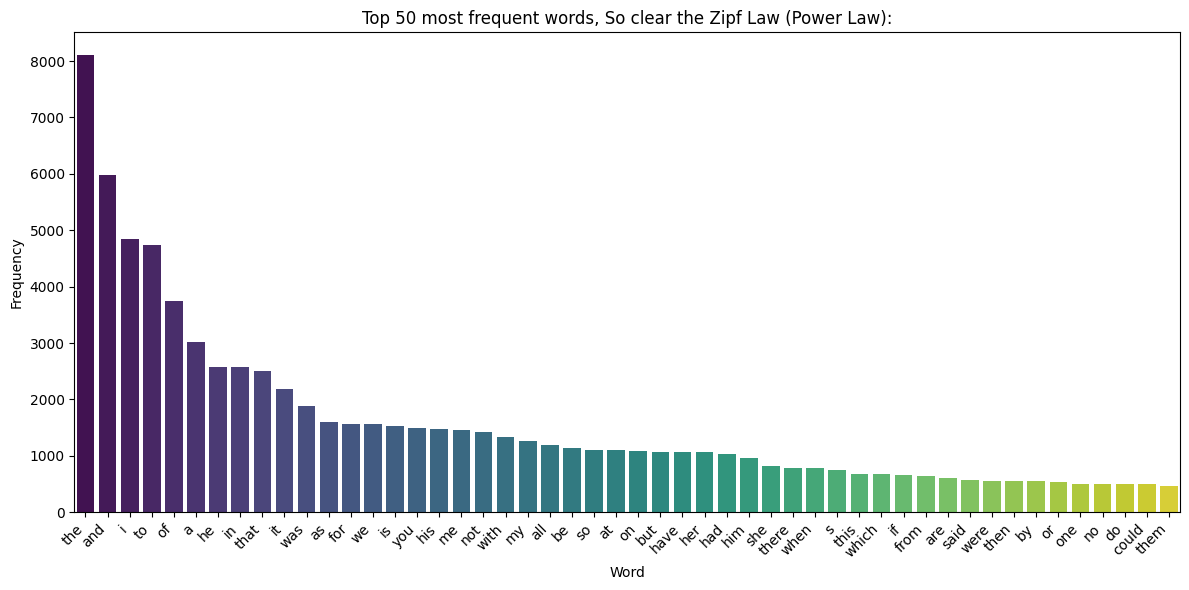

In [ ]:
# Get the "n" most frequent words:
n = 50
palabras_mas_comunes = frecuencias_palabras.most_common(n)
vocabulario, frecuencias = zip(*palabras_mas_comunes)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=list(vocabulario), y=list(frecuencias), palette='viridis', hue=list(vocabulario), legend=False)
plt.xticks(rotation=45, ha='right')
plt.title(f"Top {n} most frequent words, So clear the Zipf Law (Power Law):")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

## N-gramas y distribuciones empíricas

Los *n*-gramas son secuencias de $n$ elementos consecutivos (como palabras o caracteres) en un texto, y nos permiten capturar **patrones locales**. Por ejemplo:
- `("Hola")` es un 1-grama
- `("Hola", "cómo")` es un bigrama o 2-grama
- `("Hola", "cómo", "estás")` es un trigrama o 3-grama

La probabilidad empírica de una palabra $w$ se estima como:

$$
P(w) \approx \frac{\text{count}(w)}{\text{total de palabras}}
$$

La probabilidad condicional de una palabra $w_2$ dado que fue precedida por $w_1$ se estima como:

$$
P(w_2 \mid w_1) \approx \frac{\text{count}(w_1, w_2)}{\text{count}(w_1)}
$$

y así sucesivamente.

In [ ]:
def genera_distribucion_condicional(lista_de_palabras, n):
    # Diccionario que guarda para cada ngrama las palabras que le siguen
    dic_ngramas = defaultdict(list) # {'I am': [Pedro, the, sorry, ...]}

    for i in range(len(lista_de_palabras) - n):
        ngrama = ' '.join(lista_de_palabras[i : i + n])
        dic_ngramas[ngrama].append(lista_de_palabras[i + n])

    return dic_ngramas

In [ ]:
def genera_texto(distribucion_condicional, longitud=20):
    # Primero, seleccionamos un ngrama al azar
    ngrama = np.random.choice(list(distribucion_condicional.keys()))
    texto = ngrama
    n = len(ngrama.split())

    for _ in range(longitud):
        if ngrama not in distribucion_condicional.keys():
            break
        # Se elige una palabra de la lista de palabras posibles despues del ngrama
        siguiente_palabra = np.random.choice(distribucion_condicional[ngrama])
        texto += ' ' + siguiente_palabra
        # Cambiamos de distribución según el último ngrama
        palabras = texto.split()
        ngrama = ' '.join(palabras[len(palabras) - n : len(palabras)])

    return texto


Estos elementos nos permiten construir un modelo generativo a partir de un corpus.

Aproximamos la probabilidad condicional
$$P(\text{palabra} | w_1, w_2, \dots, w_n)$$
mediante el diccionario

`{"w_1 w_2 ... w_n: [palabra_1, ..., palabra_m]}`

## Generación de texto

### Muestreando de la distribución empiríca

In [ ]:
' '.join(np.random.choice(vocabulario, 20))  # Distribución uniforme

'as then her had is of so so were them him there be we were it in be and the'

### Cómo generar texto con bigramas

1. Empieza con una palabra inicial, por ejemplo, "the".

2. Usa la distribución empírica $ P(w_2 \mid w_1 = \text{"the"}) $ para **muestrear la siguiente palabra**.

3. Toma esa palabra generada y repite el proceso: muestreas $ P(w_3 \mid w_2) $ usando la palabra recién obtenida como contexto.

In [ ]:
dist_empirica = genera_distribucion_condicional(lista_de_palabras=libro.split(),
                                                n = 1)

In [ ]:
genera_texto(dist_empirica)

'bled freely distributed this moment before him but she was cold cold water softly quick blush overspread her fixedly the united'

### Con trigramas

La probabilidad condicional de la palabra $ w_3 $ dado el par de palabras anteriores $ (w_1, w_2) $ se estima como:

$$
P(w_3 \mid w_1, w_2) \approx \frac{\text{count}(w_1, w_2, w_3)}{\text{count}(w_1, w_2)}
$$

**Pasos para generar texto con trigramas:**

1. Comenzar con dos palabras iniciales, por ejemplo, $ w_1 $ y $ w_2 $.

2. Muestrear la siguiente palabra $ w_3 $ según la distribución $ P(w_3 \mid w_1, w_2) $.

3. Repetir usando las dos últimas palabras generadas como nuevo contexto: $ (w_2, w_3) $, y así sucesivamente.


In [ ]:
dist_empirica = genera_distribucion_condicional(lista_de_palabras=libro.split(),
                                                n = 2)

In [ ]:
genera_texto(dist_empirica)

'attention jonathan s full confidence for so i simply nodded the professor has a fearful hold upon me to bear but you'

### Y así para n-gramas

In [ ]:
dist_empirica = genera_distribucion_condicional(lista_de_palabras=libro.split(),
                                                n = 3)

In [ ]:
genera_texto(dist_empirica)

'help us mate says we must be ready to attend on her it s not too much to say that he has not'

### ¿Qué pasa si $n \rightarrow \infty$?

In [ ]:
dist_empirica = genera_distribucion_condicional(lista_de_palabras=libro.split(),
                                                n = 100)
genera_texto(dist_empirica)

'of a score the other dogs who had by now been lifted in the same manner had but small prey ere the whole mass had vanished with their going it seemed as if some evil presence had departed for the dogs frisked about and barked merrily as they made sudden darts at their prostrate foes and turned them over and over and tossed them in the air with vicious shakes we all seemed to find our spirits rise whether it was the purifying of the deadly atmosphere by the opening of the chapel door or the relief which we experienced by finding ourselves in the open i know not but most certainly the shadow of dread seemed to slip from'